In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os


def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np
import pandas as pd


from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import EnvironmentFactory
from dynamic_programming.opinion_dynamics.common.viz import (
    interpolate_opinion_trajectory,
    plot_action_heatmap,
    plot_opinions_over_time,
)
from dqn.opinion_dynamics.experiments.baseline import flatten_intermediate_states_np, run_policy_agent


def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file
    in the provided experiment subdirectory. The agent is created with the
    given training and validation environments and loads its previous state.

    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.


    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn"),
    )

    return agent




C:\Users\Chainsword\AppData\Local\Temp\ipykernel_53984\4082446625.py:18: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


2025-07-16 02:04:29,507 - dqn - INFO - opinion_dqn.py:267 - Loaded configuration settings.
2025-07-16 02:04:30,750 - dqn - INFO - opinion_dqn.py:329 - Initialized networks and optimizer.
2025-07-16 02:04:34,231 - dqn - INFO - opinion_dqn.py:212 - Loaded previous training status from the following files: {'replay_buffer_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul15-014518_configs\\0000_agent_params.args_.target_model_update_freq_2500\\2\\opinion_agent_dqn_replay_buffer', 'train_stats_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul15-014518_configs\\0000_agent_params.args_.target_model_update_freq_2500\\2\\opinion_agent_dqn_train_stats', 'checkpoint_model_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul15-014518_configs\\0000_agent_params.args_.target_model_update_freq_2500\\2\\model_checkpoints\\mck_60'}

--- Running agent on validation envir

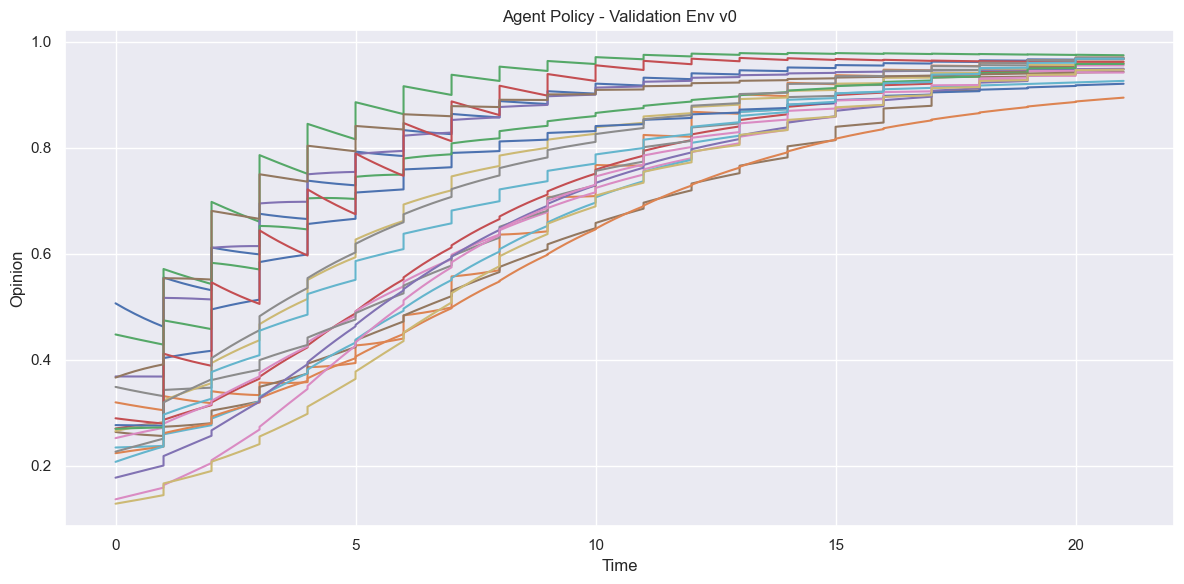

Total discounted reward: -6.1915

--- Running agent on validation environment version 1 ---
Simulation ended at step 17: done=True, truncated=False


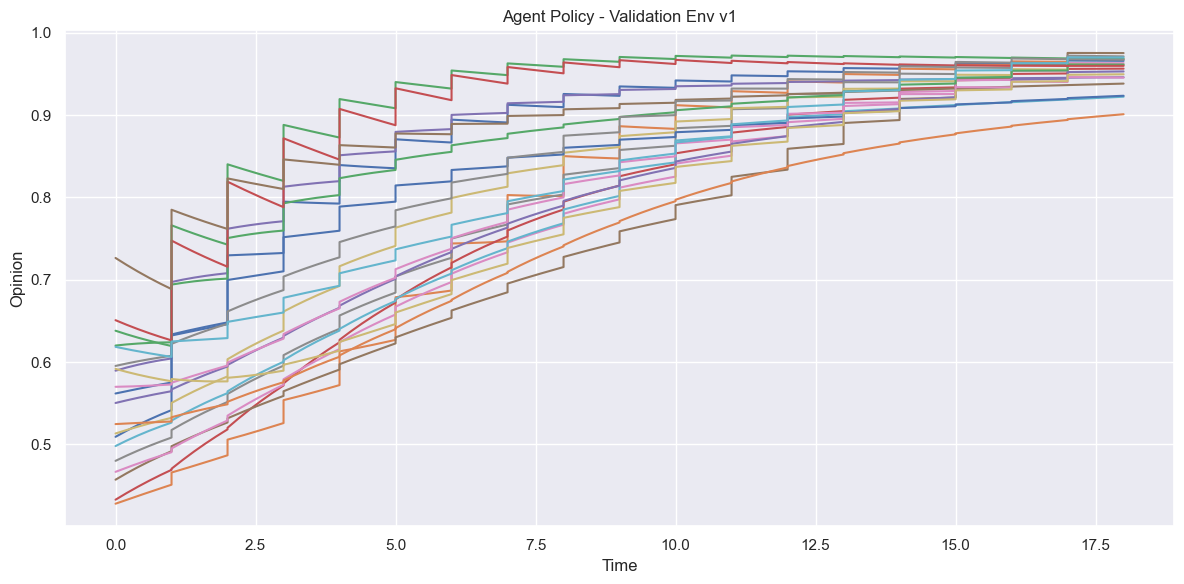

Total discounted reward: -3.6844

--- Running agent on validation environment version 2 ---
Simulation ended at step 18: done=True, truncated=False


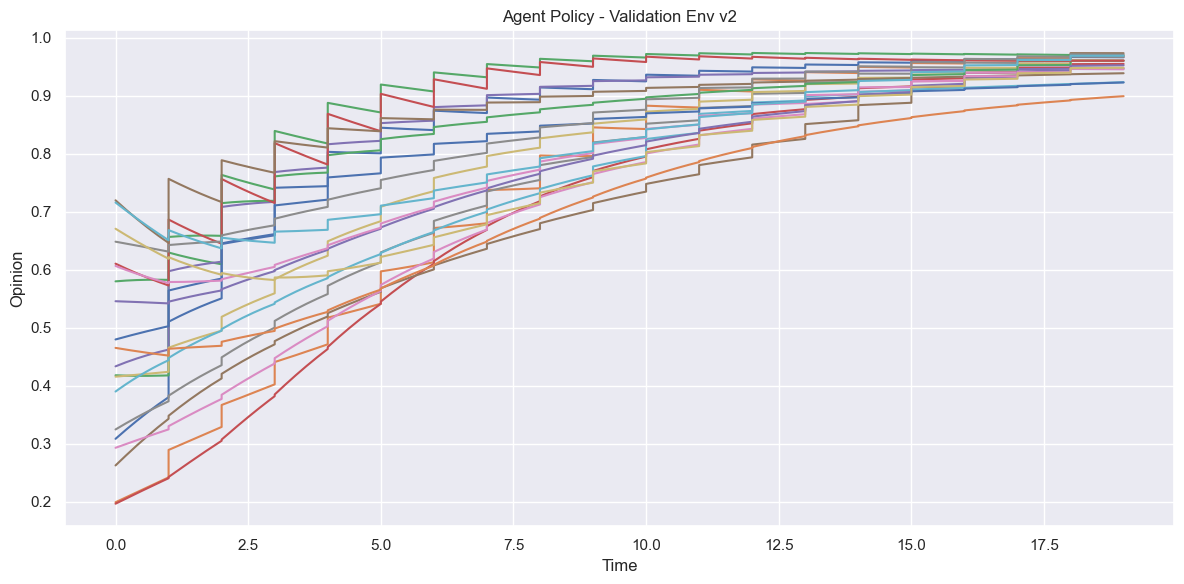

Total discounted reward: -4.4261
   version  discounted_reward
0        0          -6.191485
1        1          -3.684389
2        2          -4.426057


In [3]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May02-101004_configs\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\1" # excellent run

# was a decent run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May29-012929_configs\0000_optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.5__agent_params.args_.target_model_update_freq_1000\1"

# exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul09-171538_configs\0000_agent_params.args_.target_model_update_freq_5000__agent_params.args_.training_freq_4\2"

exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul15-014518_configs\0000_agent_params.args_.target_model_update_freq_2500\2"


agent = instantiate_agent(exp_subdir)

results = []

for version in range(len(agent.env_factory.validation_versions)):
    print(f"\n--- Running agent on validation environment version {version} ---")
    
    # Force environment to version
    agent.validation_env = agent.env_factory.get_validation_env(version=version)
    
    # Run policy with agent
    states, times, rewards, actions, all_intermediate_states = run_policy_agent(agent)

    # Flatten for plotting
    flat_states, flat_times = flatten_intermediate_states_np(
        all_intermediate_states,
        agent.validation_env.t_campaign,
        agent.validation_env.t_s
    )

    # Plot high-resolution trajectory
    plot_opinions_over_time(flat_states, flat_times, title=f"Agent Policy - Validation Env v{version}")

    # Discounted reward
    total_value = sum((agent.gamma ** i) * r for i, r in enumerate(rewards))
    print(f"Total discounted reward: {total_value:.4f}")
    results.append({"version": version, "discounted_reward": total_value})

# Summary
df_results = pd.DataFrame(results)
print(df_results)



In [4]:
len(actions)

19

In [ ]:
# TODO: beta = [0, 2] + [0, 1, 2]


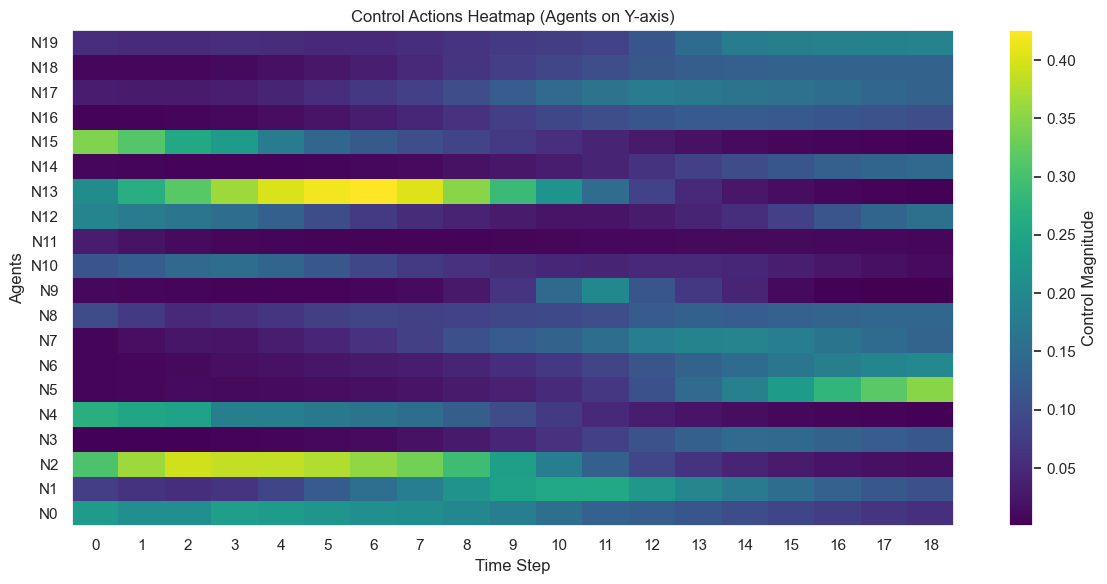

In [6]:
plot_action_heatmap(actions)

In [7]:
gamma = 0.99
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r

total_value

-4.426056816380478

In [8]:
# Add multiple budget levels
# Retrieve the budget levels used and plug into NAHS control

In [9]:
np.sum(actions, axis=1)

array([1.9999999, 2.0000002, 2.0000002, 2.       , 2.0000002, 2.       ,
       2.       , 2.       , 1.9999999, 2.       , 2.       , 2.       ,
       2.       , 2.       , 2.       , 1.9999999, 1.9999998, 1.9999999,
       1.9999999], dtype=float32)

In [10]:
sum(rewards)

-4.6281529920885545

In [11]:
# array of 20 rand elements between 0 and 1
state = np.random.rand(20)
state_tensor = torch.tensor(state, dtype=torch.float32)
(u, beta_idx, w_full, max_q) = agent.select_action(state_tensor, epsilon=1, random_action=True)

print(beta_idx)
print(u.sum())

[0]
2.0
